In [19]:
#from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Assuming the Excel file is named 'data.xlsx' and located in the current directory
file_path ="EAH_Database_all.xlsx"
df = pd.read_excel(file_path)

#replacing any statistical outliers with mean values
outlier_cols=[
       'v1_meal_g', 'v1_meal_kcal', 'v1_eah_g',
       'v1_eah_kcal', 'v1_eah_sweet_g', 'v1_eah_sweet_kcal', 'v1_eah_sav_g',
       'v1_eah_sav_kcal', 'v7_meal_g', 'v7_meal_kcal', 'v7_eah_g',
       'v7_eah_kcal', 'v7_eah_sweet_g', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal',
       'v7_eah_sav_g','v1_freddy_pre_eah']

In [20]:
def replace_outliers_with_mean(df, columns):
    # Dictionary to store the count of replaced outliers for each column
    replaced_count = {}
    
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Calculate condition for outliers
        outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        # Count outliers that will be replaced
        replaced_count[col] = outlier_condition.sum()
        
        # Replace outliers with the mean of the series
        df[col] = df[col].mask(outlier_condition, mean_val)
        
    # Optionally, return the dictionary if you want to see the counts after function execution
    return df, replaced_count

# Usage
df, count_replaced = replace_outliers_with_mean(df, outlier_cols)
print(count_replaced)

{'v1_meal_g': 0, 'v1_meal_kcal': 0, 'v1_eah_g': 1, 'v1_eah_kcal': 1, 'v1_eah_sweet_g': 0, 'v1_eah_sweet_kcal': 0, 'v1_eah_sav_g': 1, 'v1_eah_sav_kcal': 1, 'v7_meal_g': 0, 'v7_meal_kcal': 0, 'v7_eah_g': 0, 'v7_eah_kcal': 0, 'v7_eah_sweet_g': 0, 'v7_eah_sweet_kcal': 0, 'v7_eah_sav_kcal': 1, 'v7_eah_sav_g': 1, 'v1_freddy_pre_eah': 0}


In [21]:
def remove_subjects_with_outliers(df, columns):
    for col in columns:
        mean_val = df[col].mean()
        std_val = df[col].std()
        
        # Define bounds for outliers
        lower_bound = mean_val - (3 * std_val)
        upper_bound = mean_val + (3 * std_val)
        
        # Filter out rows where outliers exist in the specified columns
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Usage
outlier_cols = ['sed_simple_avg']
df = remove_subjects_with_outliers(df, outlier_cols)

In [22]:
# Filtering the dataset for subjects with actual values in the specified columns
filtered_df = df.dropna(subset=['sed_simple_avg'])

# Printing the first few rows of the filtered dataset to confirm
print(filtered_df[['sed_simple_avg']].head())

# You can also get the count of remaining subjects
remaining_subjects_count = filtered_df.shape[0]
print(f"Number of subjects with actual values: {remaining_subjects_count}")

   sed_simple_avg
0      608.388889
1      812.777778
2      824.261905
5      429.666667
6      724.583333
Number of subjects with actual values: 65


In [23]:
df_no_outliers=filtered_df.copy()

In [24]:
import pandas as pd

# df_no_outliers is your DataFrame
mean_sd_stats = df_no_outliers[['sed_simple_avg']].agg(['mean', 'std', 'min', 'max'])

# Formatting the output to two decimal places
mean_sd_stats = mean_sd_stats.map(lambda x: f"{x:.2f}")

print(mean_sd_stats)

     sed_simple_avg
mean         754.04
std           96.22
min          429.67
max          927.40


In [25]:
# Perform the median split on 'Total Sed'
median_sedentary_avg = df_no_outliers['sed_simple_avg'].median()
df_no_outliers['median_split_sedentary'] = np.where(df_no_outliers['sed_simple_avg'] > median_sedentary_avg, 1, 0)

In [26]:
# Define a function to get the statistics
def get_group_stats(df, group_col, target_col):
    stats = df.groupby(group_col)[target_col].agg(['count', 'mean', 'std']).reset_index()
    return stats

# Calculate statistics for 'Sedentary'
sedentary_stats = get_group_stats(df_no_outliers, 'median_split_sedentary', 'sed_simple_avg')
sedentary_stats.columns = ['Group (Sedentary)', 'Count', 'Mean (Sedentary)', 'Std (Sedentary)']

# Formatting the output to two decimal places
sedentary_stats[['Mean (Sedentary)', 'Std (Sedentary)']] = sedentary_stats[['Mean (Sedentary)', 'Std (Sedentary)']].map(lambda x: f"{x:.2f}")

# Print the results
print("Sedentary Stats:")
print(sedentary_stats)

Sedentary Stats:
   Group (Sedentary)  Count Mean (Sedentary) Std (Sedentary)
0                  0     33           680.57           74.95
1                  1     32           829.82           40.52


In [27]:
# Standardize the variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_columns = ['v7_FMI', 'v1_FMI', 'age_diff', 'v1_eah_kcal', 'v1_eah_sweet_kcal', 'v1_meal_kcal','v1_eah_sav_kcal','avg_wear_time']
df_no_outliers[scaled_columns] = scaler.fit_transform(df_no_outliers[scaled_columns])

# Save the original scaled data for plotting
df_unscaled = df_no_outliers.copy()


# Inverse transform the scaled variables for plotting
df_unscaled[['v7_FMI', 'v1_FMI', 'age_diff', 'v1_eah_kcal', 'v1_eah_sweet_kcal', 'v1_meal_kcal','v1_eah_sav_kcal','avg_wear_time']] = scaler.inverse_transform(df_unscaled[scaled_columns])

In [28]:
# Recoding the income column
df_no_outliers['income'] = df_no_outliers['income'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

# Recoding the parent_ed column
df_no_outliers['parent_ed'] = df_no_outliers['parent_ed'].apply(lambda x: 0 if x in [0, 1, 2] else 1)

In [29]:
# One-hot encoding for v7_p_pds_imputed
tanner_dummies = pd.get_dummies(df_no_outliers['v7_p_pds_imputed'], prefix='v7_p_pds_imputed', drop_first=True)

# Rename the columns appropriately
tanner_dummies.columns = ['v7_p_pds_imputed_2', 'v7_p_pds_imputed_3']

# Drop the original column
df_no_outliers.drop(['v7_p_pds_imputed'], axis=1, inplace=True)

# Add the one-hot encoded columns back to the dataframe
df_no_outliers = pd.concat([df_no_outliers, tanner_dummies], axis=1)

In [30]:
from scipy.stats import ttest_ind
# Columns to test
columns_to_test = [
    'v1_eah_kcal', 'v1_meal_kcal', 'v1_eah_sweet_kcal', 'v1_eah_sav_kcal', 'v1_eah_g', 'v1_meal_g', 
    'v1_eah_sweet_g', 'v1_eah_sav_g', 'v7_eah_kcal', 'v7_meal_kcal', 'v7_eah_sweet_kcal', 'v7_eah_sav_kcal', 
    'v7_eah_g', 'v7_meal_g', 'v7_eah_sweet_g', 'v7_eah_sav_g'
]

# Function to perform t-tests and collect results
def perform_ttests(df, group_col, test_cols):
    results = []
    group1 = df[df[group_col] == 0]
    group2 = df[df[group_col] == 1]
    
    for col in test_cols:
        t_stat, p_val = ttest_ind(group1[col], group2[col], nan_policy='omit')
        mean1, mean2 = group1[col].mean(), group2[col].mean()
        sd1, sd2 = group1[col].std(), group2[col].std()
        range1, range2 = (group1[col].min(), group1[col].max()), (group2[col].min(), group2[col].max())
        n1, n2 = group1[col].count(), group2[col].count()
        results.append({
            'Variable': col, 
            't-Statistic': t_stat, 
            'p-Value': p_val,
            'Group1_Mean': mean1, 
            'Group2_Mean': mean2,
            'Group1_SD': sd1, 
            'Group2_SD': sd2,
            'Group1_Range': range1, 
            'Group2_Range': range2,
            'Group1_N': n1, 
            'Group2_N': n2
        })
    
    return pd.DataFrame(results)

# Perform t-tests
ttest_results = perform_ttests(df_unscaled, 'median_split_sedentary', columns_to_test)

# Print results
print(ttest_results)

# Optional: Display results in a more readable format
with pd.option_context('display.max_columns', None):
    display(ttest_results)


             Variable  t-Statistic   p-Value  Group1_Mean  Group2_Mean  \
0         v1_eah_kcal     0.688718  0.493529   277.697649   256.278704   
1        v1_meal_kcal     1.580056  0.119102   625.757823   520.561148   
2   v1_eah_sweet_kcal     0.907918  0.367381   261.137550   233.886796   
3     v1_eah_sav_kcal    -1.862085  0.067256    16.560098    31.129397   
4            v1_eah_g     0.173622  0.862720   114.892121   111.842008   
5           v1_meal_g     1.039089  0.302735   333.666027   290.862500   
6      v1_eah_sweet_g     1.165901  0.248049    69.552727    61.093075   
7        v1_eah_sav_g    -1.851460  0.068791     3.270000     6.072969   
8         v7_eah_kcal     1.386728  0.170412   320.511618   270.836596   
9        v7_meal_kcal     0.480591  0.632472   706.755734   676.447840   
10  v7_eah_sweet_kcal     1.441418  0.154419   297.665192   246.810941   
11    v7_eah_sav_kcal    -1.690534  0.095868    13.183420    24.025655   
12           v7_eah_g     0.300032  0.

,Variable,t-Statistic,p-Value,Group1_Mean,Group2_Mean,Group1_SD,Group2_SD,Group1_Range,Group2_Range,Group1_N,Group2_N
0,v1_eah_kcal,0.688718,0.493529,277.697649,256.278704,132.440151,117.588375,"(60.37430999999995, 624.3489099999998)","(65.80187999999998, 552.9737)",33,32
1,v1_meal_kcal,1.580056,0.119102,625.757823,520.561148,270.925873,265.668805,"(137.0, 1200.1792999999998)","(55.81334000000004, 1149.93785)",33,32
2,v1_eah_sweet_kcal,0.907918,0.367381,261.137550,233.886796,123.007663,118.846912,"(60.37430999999995, 526.0904799999998)","(42.745599999999996, 552.9737)",33,32
3,v1_eah_sav_kcal,-1.862085,0.067256,16.560098,31.129397,22.946962,38.440116,"(0.0, 111.5363999999998)","(0.0, 175.64742999999993)",33,32
4,v1_eah_g,0.173622,0.862720,114.892121,111.842008,68.048174,73.550007,"(26.840000000000032, 292.33000000000004)","(14.810000000000002, 348.28999999999996)",33,32
5,v1_meal_g,1.039089,0.302735,333.666027,290.862500,167.029757,165.003717,"(96.07999999999996, 679.2000000000002)","(68.17000000000002, 657.3200000000002)",33,32
6,v1_eah_sweet_g,1.165901,0.248049,69.552727,61.093075,30.541381,27.845644,"(26.079999999999984, 142.35000000000002)","(10.650000000000006, 121.78999999999999)",33,32
7,v1_eah_sav_g,-1.851460,0.068791,3.270000,6.072969,4.433999,7.441627,"(0.0, 21.039999999999964)","(0.0, 34.609999999999985)",33,32
8,v7_eah_kcal,1.386728,0.170412,320.511618,270.836596,164.656472,119.917586,"(0.0, 665.39691)","(62.542310000000114, 503.30515999999994)",33,32
9,v7_meal_kcal,0.480591,0.632472,706.755734,676.447840,267.786813,239.341575,"(0.0, 1204.6085000000003)","(265.7185500000002, 1311.7205899999997)",33,32


In [31]:
# Fit regression models
model_sedentary_avg_meal_kcal= smf.ols('v7_FMI ~ v1_FMI + sex + risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff +avg_wear_time +v1_meal_kcal * median_split_sedentary', data=df_no_outliers).fit()

# Print model summaries
print("Model with Sedentary as moderator:")
print(model_sedentary_avg_meal_kcal.summary())

Model with Sedentary as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     23.78
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           5.86e-17
Time:                        16:09:42   Log-Likelihood:                -31.461
No. Observations:                  65   AIC:                             88.92
Df Residuals:                      52   BIC:                             117.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [32]:
# Fit regression models
model_sedentary_avg_eah_kcal= smf.ols('v7_FMI ~ v1_FMI + sex + risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_kcal * median_split_sedentary', data=df_no_outliers).fit()

# Print model summaries
print("Model with Sedentary as moderator:")
print(model_sedentary_avg_eah_kcal.summary())


Model with Sedentary as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     25.63
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           1.18e-17
Time:                        16:09:42   Log-Likelihood:                -29.387
No. Observations:                  65   AIC:                             84.77
Df Residuals:                      52   BIC:                             113.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [33]:
# Fit regression models
model_sedentary_avg_eah_sweet_kcal= smf.ols('v7_FMI ~ v1_FMI + sex + risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sweet_kcal * median_split_sedentary', data=df_no_outliers).fit()

# Print model summaries
print("Model with Sedentary as moderator:")
print(model_sedentary_avg_eah_sweet_kcal.summary())


Model with Sedentary as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     25.83
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           9.94e-18
Time:                        16:09:43   Log-Likelihood:                -29.170
No. Observations:                  65   AIC:                             84.34
Df Residuals:                      52   BIC:                             112.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [34]:
# Fit regression models
model_sedentary_avg_eah_sav_kcal= smf.ols('v7_FMI ~ v1_FMI + sex + risk_status_mom + income + parent_ed + v7_p_pds_imputed_2 + v7_p_pds_imputed_3 + age_diff + avg_wear_time+ v1_eah_sav_kcal * median_split_sedentary', data=df_no_outliers).fit()

# Print model summaries
print("Model with Sedentary as moderator:")
print(model_sedentary_avg_eah_sav_kcal.summary())


Model with Sedentary as moderator:
                            OLS Regression Results                            
Dep. Variable:                 v7_FMI   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     23.72
Date:                Thu, 05 Sep 2024   Prob (F-statistic):           6.20e-17
Time:                        16:09:43   Log-Likelihood:                -31.534
No. Observations:                  65   AIC:                             89.07
Df Residuals:                      52   BIC:                             117.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

# Graphs

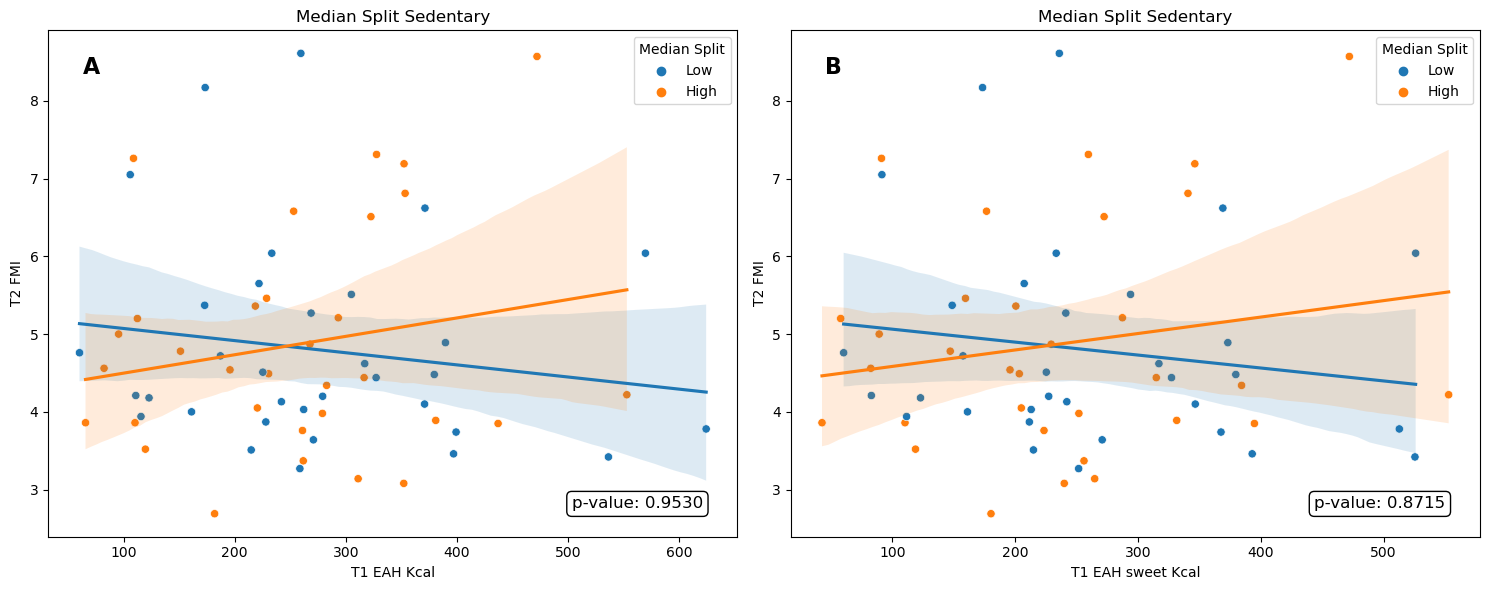

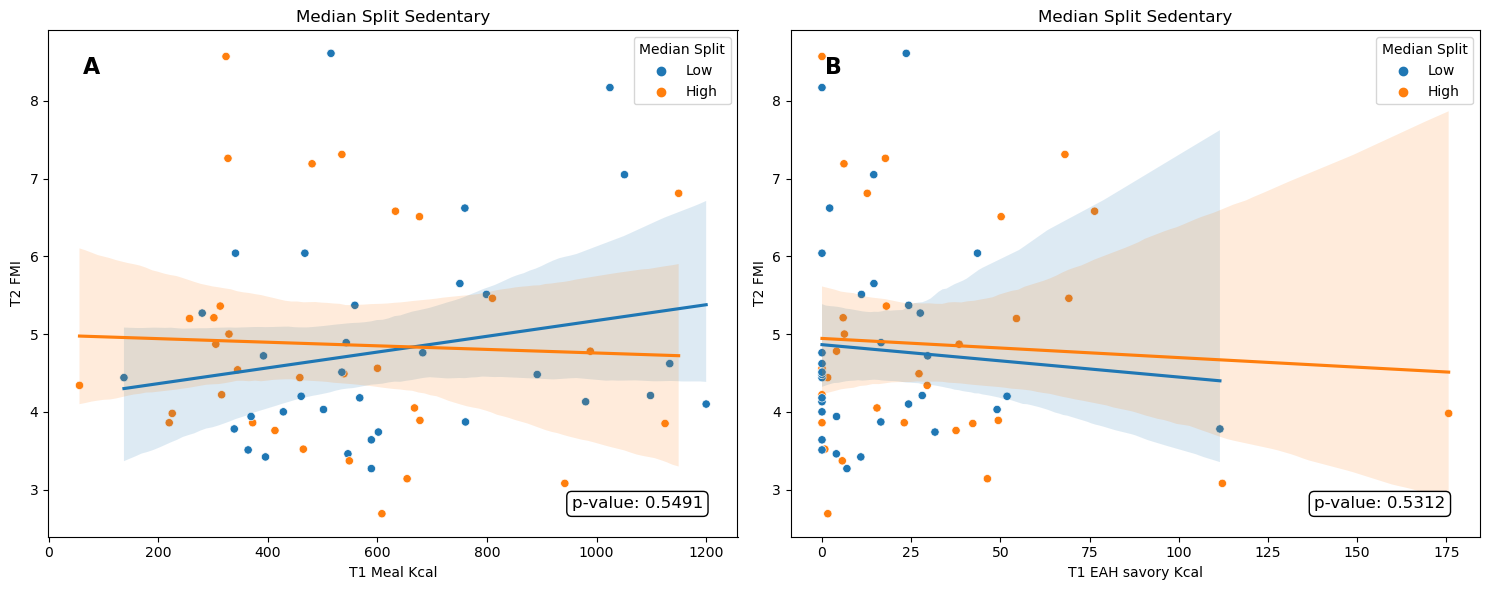

In [35]:
# Map the median split values to 'Low' and 'High'
df_unscaled['median_split_sedentary'] = df_unscaled['median_split_sedentary'].map({0: 'Low', 1: 'High'})

# Extract the p-values
p_values = {
    'v1_eah_sweet_kcal*median_split_sedentary': model_sedentary_avg_eah_sweet_kcal.pvalues['v1_eah_sweet_kcal:median_split_sedentary'],
    'v1_eah_sav_kcal*median_split_sedentary': model_sedentary_avg_eah_sav_kcal.pvalues['v1_eah_sav_kcal:median_split_sedentary'],
    'v1_eah_kcal*median_split_sedentary': model_sedentary_avg_eah_kcal.pvalues['v1_eah_kcal:median_split_sedentary'],
    'v1_meal_kcal*median_split_sedentary': model_sedentary_avg_meal_kcal.pvalues['v1_meal_kcal:median_split_sedentary'],
}

# Create subplots for EAH and EAH sweet (1x2 layout)
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 6))

# Labels for subplots
labels_eah = ['A', 'B']

# Plotting function to add scatter and regression plots with p-value
def plot_with_regression_and_pvalue(x, y, hue, data, ax, xlabel, ylabel, title, label, pvalue):
    scatter = sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    for hue_level in data[hue].unique():
        sns.regplot(x=x, y=y, data=data[data[hue] == hue_level], ax=ax, scatter=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.05, 0.95, label, transform=ax.transAxes, 
            fontsize=16, fontweight='bold', va='top', ha='left')
    ax.text(0.95, 0.05, f"p-value: {pvalue:.4f}", transform=ax.transAxes,
            fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    handles, labels = scatter.get_legend_handles_labels()
    ax.legend(handles=handles[:2], labels=['Low', 'High'], title='Median Split', loc='upper right')

# Plotting for v1_eah_kcal
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', 'median_split_sedentary', df_unscaled, axes1[0], 'T1 EAH Kcal', 'T2 FMI', 'Median Split Sedentary', labels_eah[0], p_values['v1_eah_kcal*median_split_sedentary'])

# Plotting for v1_eah_sweet_kcal
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', 'median_split_sedentary', df_unscaled, axes1[1], 'T1 EAH sweet Kcal', 'T2 FMI', 'Median Split Sedentary', labels_eah[1], p_values['v1_eah_sweet_kcal*median_split_sedentary'])

plt.tight_layout()
plt.show()

# Create subplots for meal and EAH savory (1x2 layout)
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# Labels for subplots
labels_meal = ['A', 'B']

# Plotting for v1_meal_kcal
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', 'median_split_sedentary', df_unscaled, axes2[0], 'T1 Meal Kcal', 'T2 FMI', 'Median Split Sedentary', labels_meal[0], p_values['v1_meal_kcal*median_split_sedentary'])

# Plotting for v1_eah_sav_kcal
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', 'median_split_sedentary', df_unscaled, axes2[1], 'T1 EAH savory Kcal', 'T2 FMI', 'Median Split Sedentary', labels_meal[1], p_values['v1_eah_sav_kcal*median_split_sedentary'])

plt.tight_layout()
plt.show()


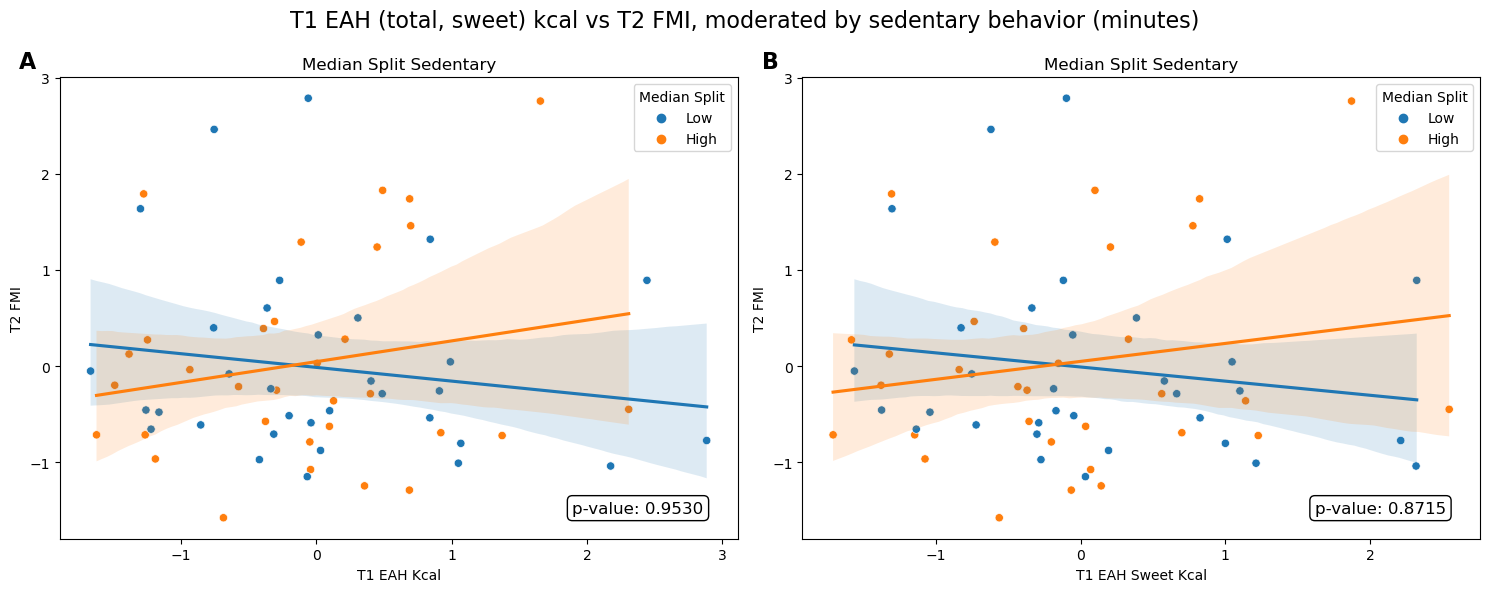

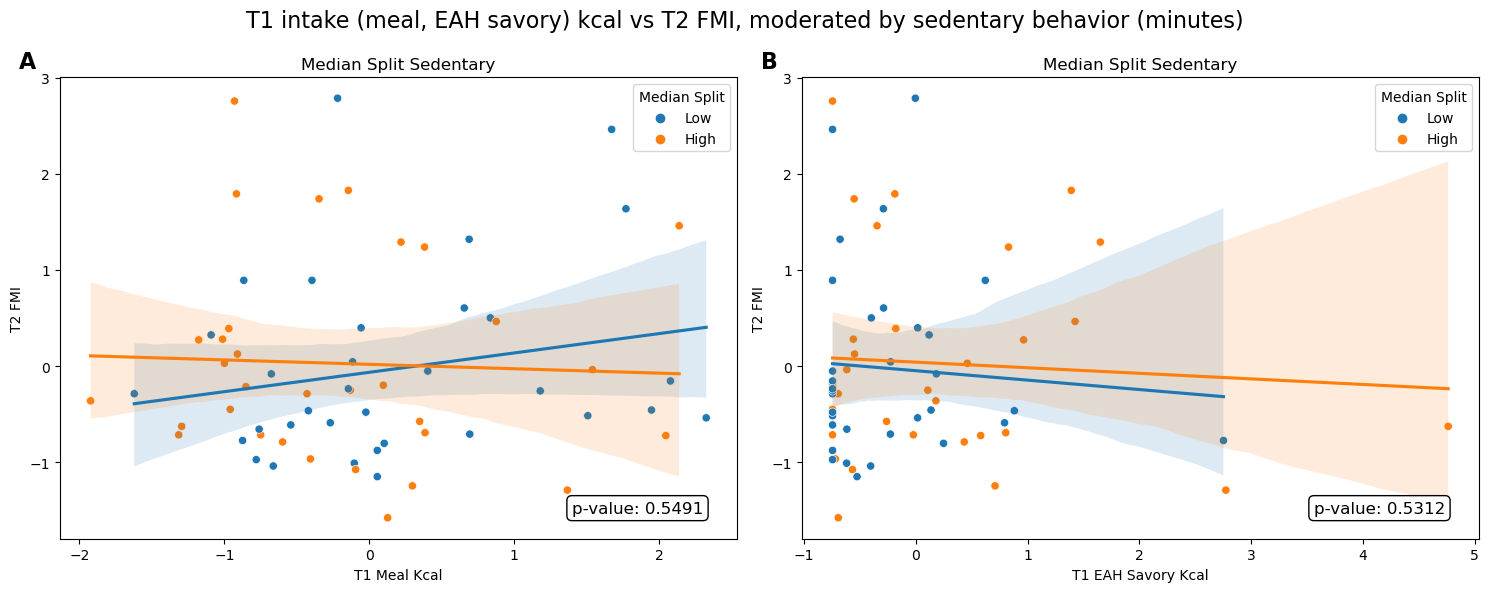

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting function to add scatter and regression plots with p-value
def plot_with_regression_and_pvalue(x, y, hue, data, ax, xlabel, ylabel, title, pvalue):
    scatter = sns.scatterplot(x=x, y=y, hue=hue, data=data, ax=ax)
    for hue_level in data[hue].unique():
        sns.regplot(x=x, y=y, data=data[data[hue] == hue_level], ax=ax, scatter=False)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.text(0.95, 0.05, f"p-value: {pvalue:.4f}", transform=ax.transAxes,
            fontsize=12, va='bottom', ha='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
    handles, labels = scatter.get_legend_handles_labels()
    ax.legend(handles=handles[:2], labels=['Low', 'High'], title='Median Split', loc='upper right')

# Create subplots for EAH and EAH sweet (1x2 layout)
fig1, axes1 = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for v1_eah_kcal
plot_with_regression_and_pvalue('v1_eah_kcal', 'v7_FMI', 'median_split_sedentary', df_no_outliers, axes1[0], 
                                'T1 EAH Kcal', 'T2 FMI', 'Median Split Sedentary', p_values['v1_eah_kcal*median_split_sedentary'])
axes1[0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plotting for v1_eah_sweet_kcal
plot_with_regression_and_pvalue('v1_eah_sweet_kcal', 'v7_FMI', 'median_split_sedentary', df_no_outliers, axes1[1], 
                                'T1 EAH Sweet Kcal', 'T2 FMI', 'Median Split Sedentary', p_values['v1_eah_sweet_kcal*median_split_sedentary'])
axes1[1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

plt.suptitle("T1 EAH (total, sweet) kcal vs T2 FMI, moderated by sedentary behavior (minutes)", fontsize=16)
plt.tight_layout()
plt.show()

# Create subplots for meal and EAH savory (1x2 layout)
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))

# Plotting for v1_meal_kcal
plot_with_regression_and_pvalue('v1_meal_kcal', 'v7_FMI', 'median_split_sedentary', df_no_outliers, axes2[0], 
                                'T1 Meal Kcal', 'T2 FMI', 'Median Split Sedentary', p_values['v1_meal_kcal*median_split_sedentary'])
axes2[0].annotate('A', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

# Plotting for v1_eah_sav_kcal
plot_with_regression_and_pvalue('v1_eah_sav_kcal', 'v7_FMI', 'median_split_sedentary', df_no_outliers, axes2[1], 
                                'T1 EAH Savory Kcal', 'T2 FMI', 'Median Split Sedentary', p_values['v1_eah_sav_kcal*median_split_sedentary'])
axes2[1].annotate('B', xy=(-0.06, 1.02), xycoords='axes fraction', fontsize=16, weight='bold')

plt.suptitle("T1 intake (meal, EAH savory) kcal vs T2 FMI, moderated by sedentary behavior (minutes)", fontsize=16)
plt.tight_layout()
plt.show()
